# First attempt to pythonise Mike's code and apply it to MERRA2

In [1]:
import sys
import os
import glob
import xarray as xr
import numpy as np
import gc
import logging
import pandas as pd
from math import pi

In [2]:
#relevant directories (move to utils.py eventually)
MERRA2_T2M_U2M_QV2M_dir = '/g/data/rr7/MERRA2/raw/M2T1NXSLV.5.12.4'
MERRA2_SWNETSRF_dir = '/g/data/rr7/MERRA2/raw/M2T1NXINT.5.12.4'
MERRA2_SWGDN_dir = '/g/data/rr7/MERRA2/raw/M2T1NXRAD.5.12.4/'

#### Dask + warning setup

In [3]:
import warnings
import logging
warnings.filterwarnings('ignore') 
logging.getLogger("distributed.worker.memory").setLevel(logging.ERROR)
logging.getLogger('flox').setLevel(logging.WARNING)

In [4]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37307,Workers: 10
Dashboard: /proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 586.73 GiB
Comm: tcp://127.0.0.1:38299,Total threads: 1
Dashboard: /proxy/36583/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:34447,


### Step 1 -> Extract daily T, q, Rd, U10 and convert to 7-day running means 

Hourly MERRA2 files are very large - extract only relevant variables for domain of interest with dask and write locally (only need to do this step once)<br>
<sub>Need to write locally as working with dask arrays using .compute crashes the session and takes a long time</sub>

In [5]:
%%time
#load in 2m air temperature (K), 2m eastward wind speed (m/s), 2m specific humidity (kg/kg) and aggregate to daily timescale
T2M_U2M_QV2M_files = []
for year in range(1980,2023):
    for month in range(1,13):
        T2M_U2M_QV2M_files.extend(sorted(glob.glob(f"{MERRA2_T2M_U2M_QV2M_dir}/{year}/{str(month).zfill(2)}/*.nc4")))

def preprocess_T2M_U2M_QV2M(ds): #preprocess function to save memory and time
    logging.getLogger('flox').setLevel(logging.WARNING)
    return ds[['T2M', 'U2M', 'QV2M']].resample(time='1D').mean().sel(lat=slice(-45,-1), lon=slice(100,180))

T2M_U2M_QV2M_cube = xr.open_mfdataset(T2M_U2M_QV2M_files,combine='nested', concat_dim='time',parallel=True, preprocess=preprocess_T2M_U2M_QV2M, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'})

#write to netcdf and clear up local memory, ok to store locally only takes ~1.5gb
T2M_U2M_QV2M_cube.to_netcdf('/g/data/mn51/users/jb6465/MERRA2_daily_T2M_U2M_QV2M.nc', encoding={'T2M': {'zlib': True, 'complevel': 5, 'dtype':'float32'}, 'U2M': {'zlib': True, 'complevel': 5, 'dtype':'float32'}, 'QV2M': {'zlib': True, 'complevel': 5, 'dtype':'float32'}})
del T2M_U2M_QV2M_cube
gc.collect()

CPU times: user 1h 33min 55s, sys: 6min 2s, total: 1h 39min 58s
Wall time: 2h 15min 1s


15373

In [6]:
%%time
#load in incoming surface solar radiation (W/m2) and aggregate to daily timescale
SWGDN_files = []
for year in range(1980,2023):
    for month in range(1,13):
        SWGDN_files.extend(sorted(glob.glob(f"{MERRA2_SWGDN_dir}/{year}/{str(month).zfill(2)}/*.nc4")))

def preprocess_SWdn(ds): #preprocess function to save memory and time
    logging.getLogger('flox').setLevel(logging.WARNING)
    return ds['SWGDN'].resample(time='1D').mean().sel(lat=slice(-45,-1), lon=slice(100,180))

SWGDN_cube = xr.open_mfdataset(SWGDN_files,combine='nested', concat_dim='time',parallel=True, preprocess=preprocess_SWdn, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'})

#write to netcdf and clear up local memory, ok to store locally only takes ~500mb
SWGDN_cube.to_netcdf('/g/data/mn51/users/jb6465/MERRA2_daily_SWGDN.nc', encoding={'SWGDN': {'zlib': True, 'complevel': 5, 'dtype':'float32'}})
del SWGDN_cube
gc.collect()

CPU times: user 34min 1s, sys: 1min 54s, total: 35min 56s
Wall time: 46min 33s


13735

<br> 

### Step 2 -> Calculate daily reference ET and convert to 7-day running means

<br>Inputs

In [3]:
T2M_U2M_QV2M_cube = xr.open_dataset('/g/data/mn51/users/jb6465/MERRA2_daily_T2M_U2M_QV2M.nc')
SWGDN_cube = xr.open_dataset('/g/data/mn51/users/jb6465/MERRA2_daily_SWGDN.nc')

T2M = T2M_U2M_QV2M_cube['T2M'] #2-m daily mean air temperature [K]
U2M = T2M_U2M_QV2M_cube['U2M'] #2-m eastward wind speed [m/s]
QV2M = T2M_U2M_QV2M_cube['QV2M'] #2-m specific humidity [kg/kg]
SWGDN = SWGDN_cube['SWGDN'] #surface downware shortwave radiation flux [W/m2]

<br>Elevation - following approach from Mike's [MERRA2 paper code](https://www.sciencebase.gov/catalog/item/6515cb7ad34e469cabfcdccd), elev file not stored on gadi so downloaded locally from NASA earthdata

In [4]:
elevfile = xr.open_dataset('/g/data/mn51/users/jb6465/MERRA2_101.const_2d_asm_Nx.nc4')

geopot = elevfile['PHIS'].sel(lat=slice(-45,-1), lon=slice(100,180))[0]
elev = geopot/9.81 #divide by 9.81m2/s to get elevation [m]

<br>Switch for short crop (0.12m grass) or tall crop (0.50m alfafa)

In [5]:
short_tall_crop_switch = 'short' #short (0.12m grass) or tall (0.50m alfafa)

### Ref ET using [FAO56](https://github.com/jb6465/flash-drought/blob/main/relevant_studies/FAO56.pdf) units

<br>Constants

In [68]:
# Cn: numerator crop constant [K.mm.s3/(kg.day)]
Cn = 1600 if short_tall_crop_switch == 'tall' else 900 

In [69]:
# Cd: denominator crop constant [s/m]
Cd = 0.38 if short_tall_crop_switch == 'tall' else 0.34

In [96]:
# Gsc: solar constant [MJ/(m2.hr)]
Gsc = 4.92

In [71]:
# sigma: Stefan-Boltzmann constant [MJ/(K4.m2.day)]
sigma = 4.901e-9

In [72]:
# albedo [unitless]
albedo = 0.23

<br>Input variables

In [73]:
# Rs: downwelling short wave radiation [MJ/(m2.day)]
Rs = (SWGDN * 86400)/1e6

In [74]:
# T: daily mean temperature [°C]
T = T2M-273.15

In [75]:
# Patm: surface pressure [kPa] = f(elev[m])                                               [FAO56 Eq. 7]
Patm = 101.3 * ((293. - 0.0065 * elev) / 293.)**5.26

In [83]:
# gamma: psychrometric constant [kPa/°C]                                                  [FAO56 Eq. 8]
gamma = 0.665e-3 * Patm

In [84]:
# esat: saturated vapor pressure [kPa] = f(T[°C])                                         [FAO56 Eq. 11]
esat = 0.6108 * np.exp((17.27*T/(T+237.3)))

In [85]:
# w: mixing ratio [kg/kg] = f(QV2M[kg/kg])                                                [FAO56 Eq. ???]
w = QV2M / (1. - QV2M)

In [86]:
# eact: actual vapor pressure [kPa] = f(Patm[Pa], w[kg/kg])                               [FAO56 Eq. ???]
eact = (Patm * w) / (0.622 + w)
eact = eact.clip(max=esat) #clip eact ≤ esat

In [87]:
# delta: slope of the saturated vapor pressure curve at T [kPa/°C] = f(T[°C])             [FAO56 Eq. 13]
delta = (4098. * 0.6108 * np.exp(17.27 * T / (T + 237.3))) / (T + 237.3)**2 

In [89]:
# G: ground heat flux  [MJ/(m2.day)], on daily time scales, G ≈ 0                         [FAO56 Eq. 42]
G = 0 

In [90]:
# decl: declination [radians] = f(pi[unitless], jday[unitless])                           [FAO56 Eq. 42]
jday = xr.DataArray(SWGDN.time.dt.dayofyear.values, coords=[('day', SWGDN.time.dt.dayofyear.values)], dims=["day"])
decl = 0.409 * np.sin((2. * np.pi * jday / 365) - 1.39)

In [91]:
# ws: sunset hour angle ws[radians] = f(latitude[rad], dec[rad])                          [FAO56 Eq. 25]
Lat = SWGDN.lat
ws = np.arccos(-1 * np.tan(np.deg2rad(Lat)) * np.tan(decl))

In [92]:
# dr: inverse relative distance of earth from sun [unitless]                              [FAO56 Eq. 23]
dr = 1. + 0.033 * np.cos(2. * np.pi * jday / 365)

In [97]:
# Ra: extra-terrestrial (TOA) SW radiation [MJ/(m2.day)] = 
#f(Gsc [MJ/m2/hour], dr [unitless], ws [rad], Lat [rad], decl [rad])                      [FAO56 Eq. 21] 
Ra = (24. / np.pi) * Gsc * dr * (ws * np.sin(np.deg2rad(Lat)) * np.sin(decl) + np.cos(np.deg2rad(Lat)) * np.cos(decl) * np.sin(ws))

In [98]:
# Rso: clear-sky SW radiation at surface [MJ/m2/day] = f(Ra[MJ/(m2.day)], elev[m])        [FAO56 Eq. 37]
Rso = Ra * (0.75 + 2e-5 * elev)

In [61]:
# fcd: cloudiness function [unitless]                                                     [FAO56 pg. 79]
RsRso = xr.DataArray((Rs.values)/(Rso.values), coords=[('time', Rs.time.values), ('lat', Rs.lat.values), ('lon', SWGDN.lon.values)], dims=["time", "lat", "lon"])
RsRso = RsRso.clip(min=0.3, max=1.0)
fcd = 1.35 * RsRso - 0.35 
fcd = fcd.clip(min=0.05, max=1.0) #clip values between 0.05 and 1.0

In [100]:
# Rns: Net shortwave radiation  [MJ/(m2.day)]                                            [FAO56 Eq. 38]
Rns = (1 - albedo) * Rs

In [101]:
# Rnl: net LW radiation upward[MJ/(m2.day)] = f(sigma [J/(K4.m2.day)], eact[Pa], T[°C])  [FAO56 Eq. 39]
Rnl = sigma * fcd * (0.34 - 0.14 * (0.001 * eact)**0.5) * (T + 273.15)**4.

In [102]:
# Rn: net radiation [MJ/(m2.day)]
Rn = Rns - Rnl

<br><b>Split ET0 into 3 components: A, B, C</b><br>
From FAO56, Equation 6, PM derivation of ET0
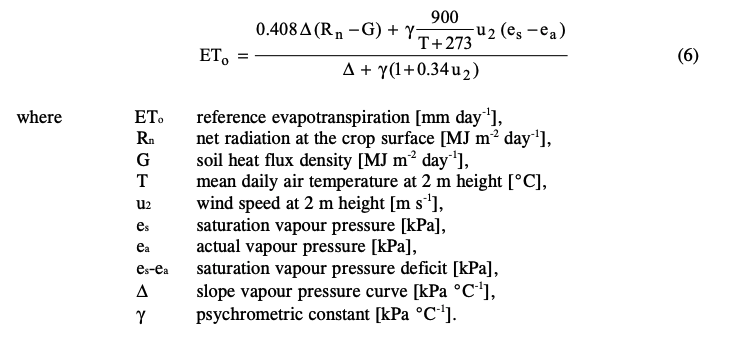

In [103]:
%%time
# A left numerator
A = 0.408 * delta * (Rn - G)

# B right numerator
B = gamma * (Cn/(T+273)) * U2M * (esat-eact)

# C denominator
C = (delta + gamma * (1+Cd*U2M))

ET0 = (A+B)/C

CPU times: user 2.41 s, sys: 3.08 s, total: 5.49 s
Wall time: 5.48 s


In [108]:
ET0_xr = xr.DataArray(ET0, dims=['time', 'lat', 'lon'], coords={'time':T.time.values, 'lat': T.lat.values, 'lon': T.lon.values}).rename(f"ET0_{short_tall_crop_switch}_crop")

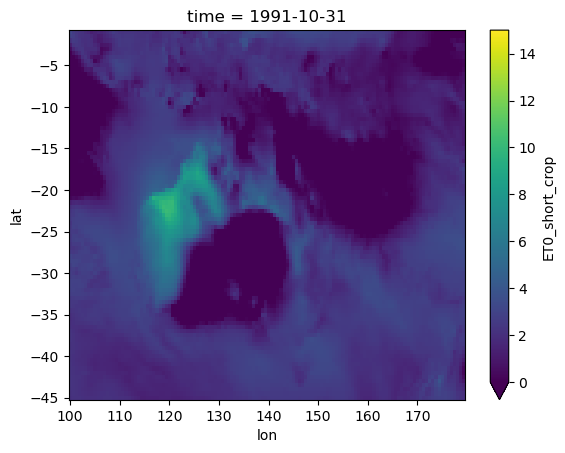

In [109]:
ET0_xr[4321].plot(vmin=0, vmax=15)

<br>

### Step 3 -> Calculate daily sensitivity expressions

Relevant Equations

<br>

### Step 4 -> Calculate relative contribution from each driver

<br>

### Step 5 -> Plot and visualise 